# L1 filtering schemes

## Application to trend-stationary process

### Model 1 with HP Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import cvxpy as cp
from scipy.sparse import spdiags
import yfinance as yf
import pandas as pd

In [2]:
# Génération des données du Modèle 1
def generate_model1_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 1 avec des tendances perturbées.
    """
    #np.random.seed(42)
    x_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            x_t[t] = x_t[t - 1] + v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
            x_t[t] = x_t[t - 1] + v_t
    noise = np.random.normal(0, sigma, n)
    y_t = x_t + noise
    return x_t, y_t

# Génération des données du Modèle 2
def generate_model2_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 2 avec une marche aléatoire perturbée.
    """
    #np.random.seed(42)
    y_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            v_t = v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
        y_t[t] = y_t[t - 1] + v_t + np.random.normal(0, sigma)
    return y_t

In [3]:
# Appliquer le filtre HP
def apply_HP_filter(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) à une série temporelle y.
    """
    n = len(y)
    D = diags([1, -2, 1], [0, 1, 2], shape=(n - 2, n))  # Opérateur D
    DTD = D.T @ D  # D^T * D
    I = diags([1], [0], shape=(n, n))  # Matrice identité
    # Résolution de l'équation linéaire pour obtenir x_t
    A = I + lambda_val * DTD
    x = spsolve(A, y)
    return x

def apply_HP_filter_cvxpy(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) avec CVXPY pour une valeur donnée de lambda.
    """
    n = len(y)
    # Construction de la matrice D pour la régularisation
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    # Définition de la variable d'optimisation
    x = cp.Variable(n)
    # Fonction objectif
    objective = cp.Minimize(0.5 * cp.sum_squares(y - x) + lambda_val * cp.norm(D @ x, p=2))
    # Problème d'optimisation
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS)
    return np.array(x.value), problem.value

# Fonction pour générer la matrice de différences
def getD(n, diff_order=2):
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    for _ in range(diff_order - 2):
        D = np.diff(D, axis=0)
    return D
    
def optimize_l1_filter(y, D, lambda_val, solver=cp.OSQP, lambda_step=0.9, min_lambda=1e-2):
    """
    Optimise le filtre L1 avec ajustement dynamique de lambda en cas de non-convergence.

    Args:
        y (array): Série temporelle.
        D (array): Matrice de différences.
        lambda_val (float): Paramètre de régularisation initial.
        solver (cvxpy solver): Solveur pour l'optimisation.
        lambda_step (float): Facteur de réduction pour lambda en cas de non-convergence.
        min_lambda (float): Valeur minimale de lambda.

    Returns:
        array: Signal optimisé.
    """
    n = len(y)
    y_norm = (y - np.mean(y)) / np.std(y)  # Normalisation des données

    while lambda_val > min_lambda:
        # Définition de la variable d'optimisation
        x = cp.Variable(n)
        objective = cp.Minimize(0.5 * cp.sum_squares(y_norm - x) + lambda_val * cp.norm(D @ x, p=1))
        problem = cp.Problem(objective)
        
        try:
            problem.solve(solver=solver)
            if problem.status == cp.OPTIMAL:
                #print(f"Convergence réussie pour lambda = {lambda_val:.2f}")
                return np.array(x.value) * np.std(y) + np.mean(y)  # Dé-normalisation
            else:
                raise cp.SolverError("Solveur non convergent")
        except cp.SolverError:
            print(f"Problème non convergent pour lambda = {lambda_val:.2f}, réduction de lambda...")
            lambda_val *= lambda_step  # Réduction de lambda

    print("Échec de convergence : lambda est descendu en dessous de la borne minimale.")
    return np.zeros(n)  # Retourne un signal nul en cas d'échec complet


def l1tf_mix(x, lambda1, lambda2, k1=1, k2=2):
    """L1 filtering with mixed differences."""
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = (
        0.5 * cp.sum_squares(x - trend)
        + lambda1 * cp.norm1(cp.diff(trend, k=k1))
        + lambda2 * cp.norm1(cp.diff(trend, k=k2))
    )
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return trend.value

def calibrate_lambda_fixed(y, periods=1, lambda_max_cap=1e4):
    """
    Calibre lambda en fonction d'une période fixe avec une borne maximale pour λ.

    Args:
        y (array): Série temporelle.
        periods (int): Nombre de périodes pour diviser les données.
        lambda_max_cap (float): Borne maximale pour λ.

    Returns:
        lambda_val (float): Valeur moyenne de lambda calibrée.
    """
    n = len(y)
    lambdas = []
    period_size = n // periods

    for i in range(periods):
        start, end = i * period_size, (i + 1) * period_size
        y_segment = y[start:end]
        
        # Normalisation des données pour la stabilité
        y_segment = (y_segment - np.mean(y_segment)) / np.std(y_segment)

        # Recalcule la matrice D pour le segment
        D_segment = getD(len(y_segment), diff_order=2)
        
        # Calcule λmax avec borne
        lambda_max = np.linalg.norm(np.linalg.solve(D_segment @ D_segment.T, D_segment @ y_segment), ord=np.inf)
        lambdas.append(min(lambda_max, lambda_max_cap))  # Cap à lambda_max_cap
    
    lambda_avg = np.mean(lambdas)
    print(f"Calibrated λ (average): {lambda_avg}")
    return lambda_avg

Calibrated λ (average): 999.9858679186462


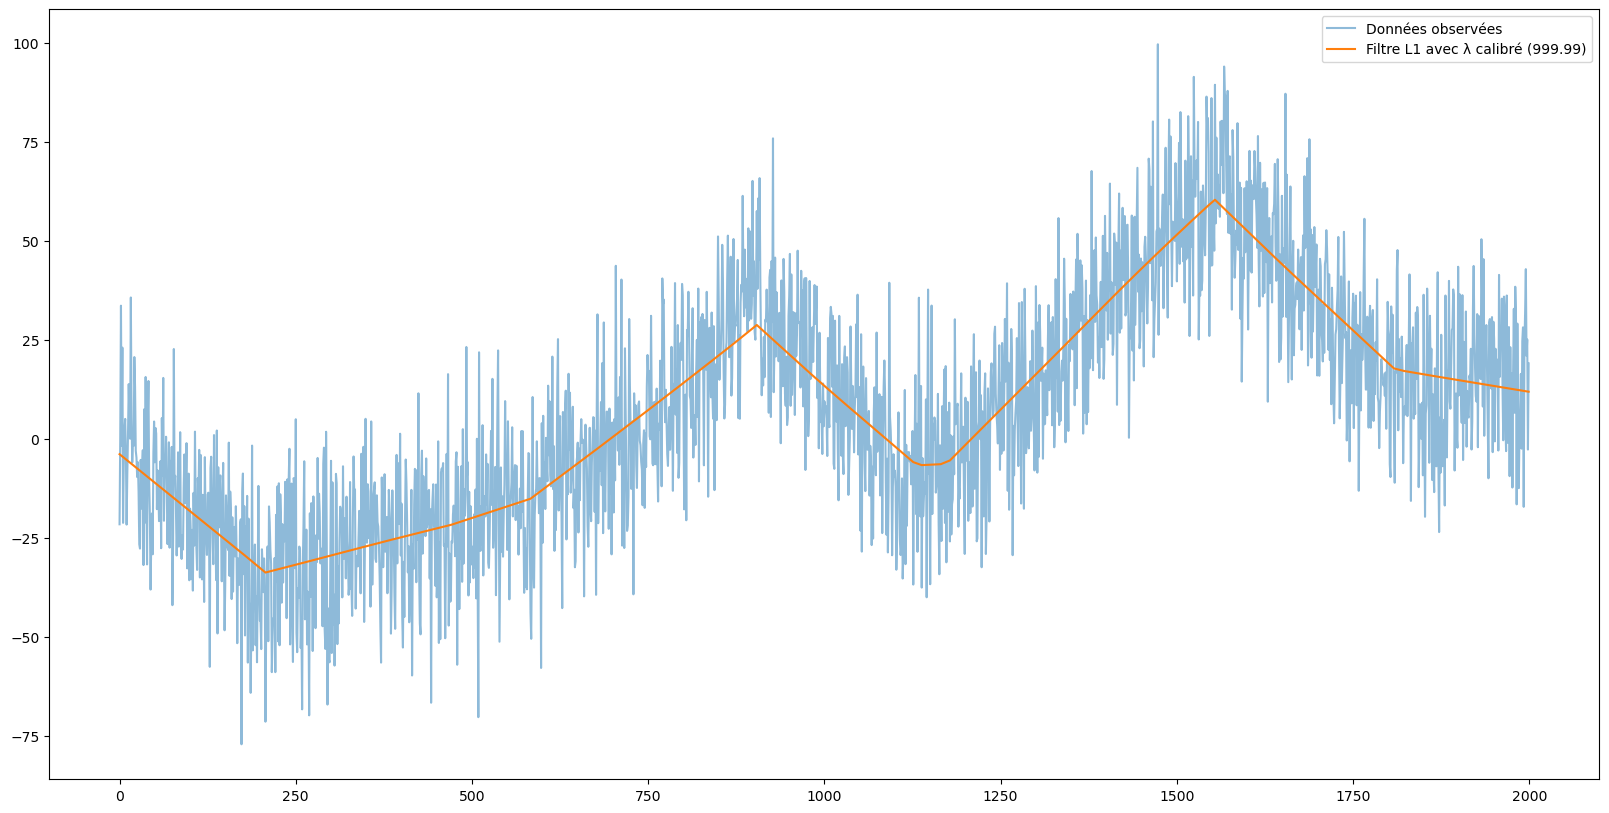

In [4]:
# Données générées
n = 2000
sigma = 15
p = 0.99
b = 0.5
lambda_HP = 1217464  # Paramètre de régularisation pour le filtre HP
x_true, y_data = generate_model1_data(n, sigma, p, b)

# Méthode 1 : Ajustement pour une période donnée avec borne et normalisation
lambda_fixed = calibrate_lambda_fixed(y_data, periods=7, lambda_max_cap=1e4)

# Matrice D pour la série complète
D = getD(n, diff_order=2)

# Applique le filtre L1 avec la nouvelle valeur de λ calibrée
x_filtered_fixed = optimize_l1_filter(y_data, D, lambda_fixed)

# Affiche le résultat
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y_data, label="Données observées", alpha=0.5)
plt.plot(x_filtered_fixed, label=f"Filtre L1 avec λ calibré ({lambda_fixed:.2f})")
plt.legend()
plt.show()


### Model 2 with HP Filter

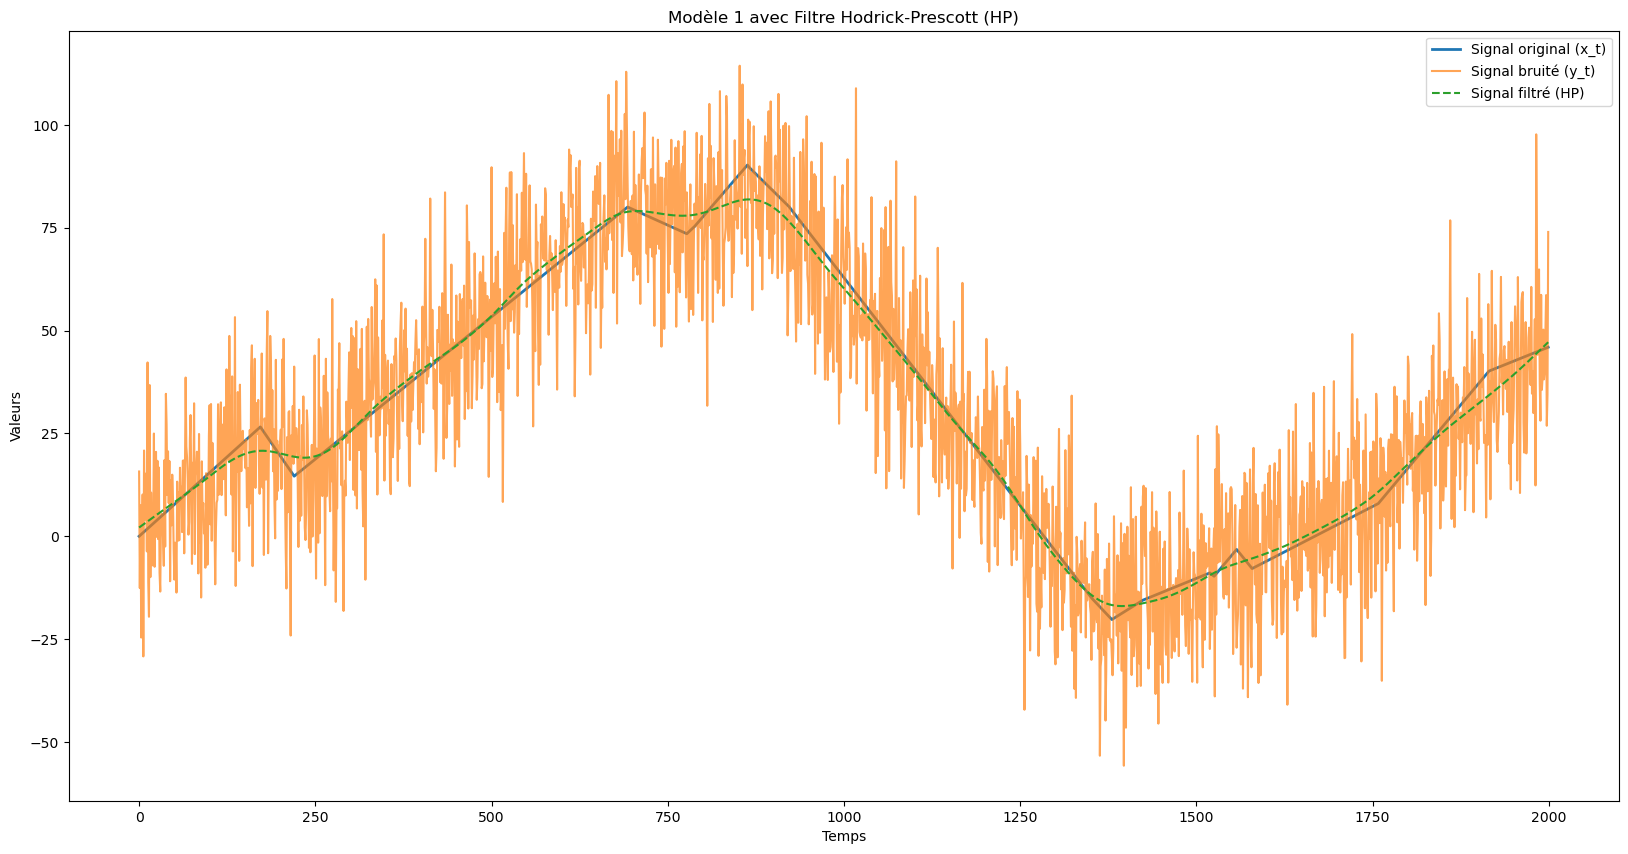

In [5]:
# Générer les données
x_t, y_t = generate_model1_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 1 avec Filtre Hodrick-Prescott (HP)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

/Users/kingced/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


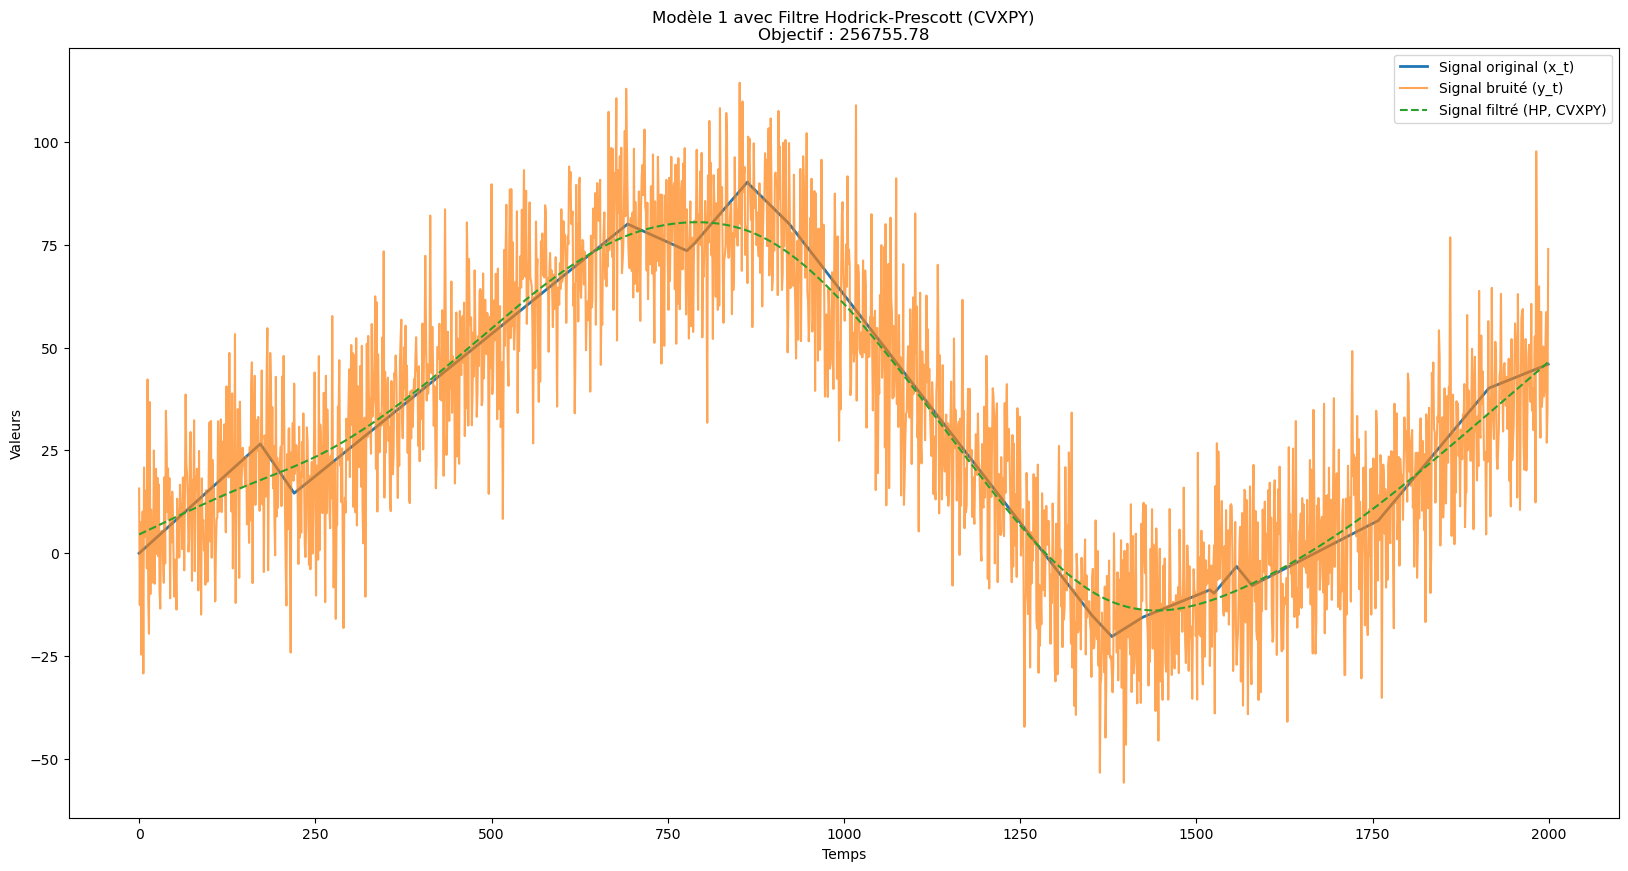

In [6]:
# Appliquer le filtre HP avec CVXPY
x_HP_cvxpy, objective_value = apply_HP_filter_cvxpy(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP_cvxpy, label="Signal filtré (HP, CVXPY)", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre Hodrick-Prescott (CVXPY)\nObjectif : {objective_value:.2f}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

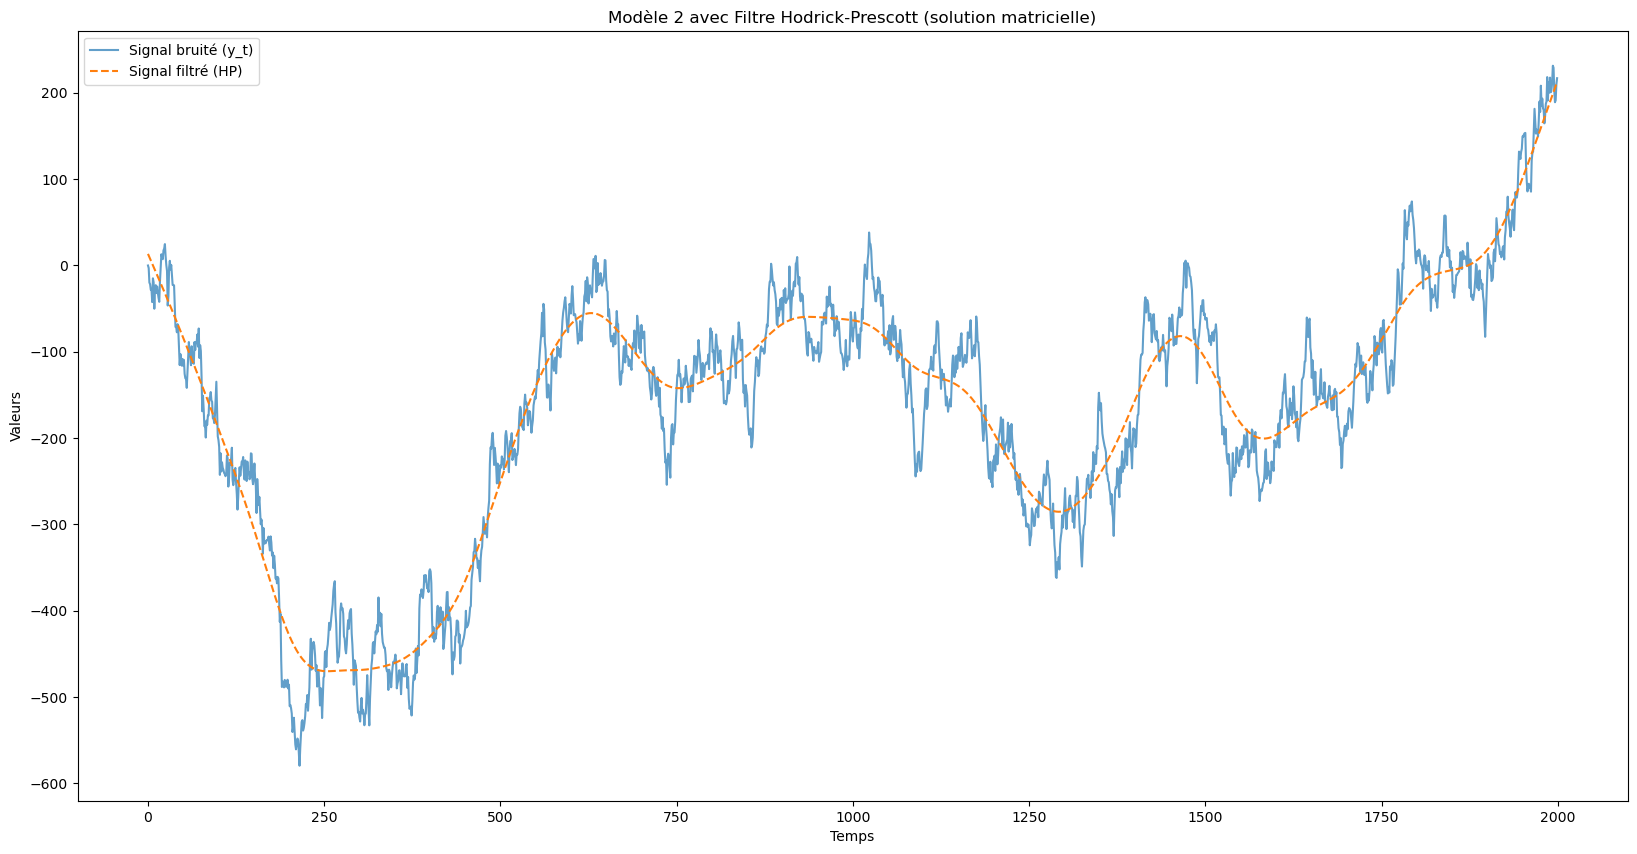

In [7]:
# Générer les données
y_t = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

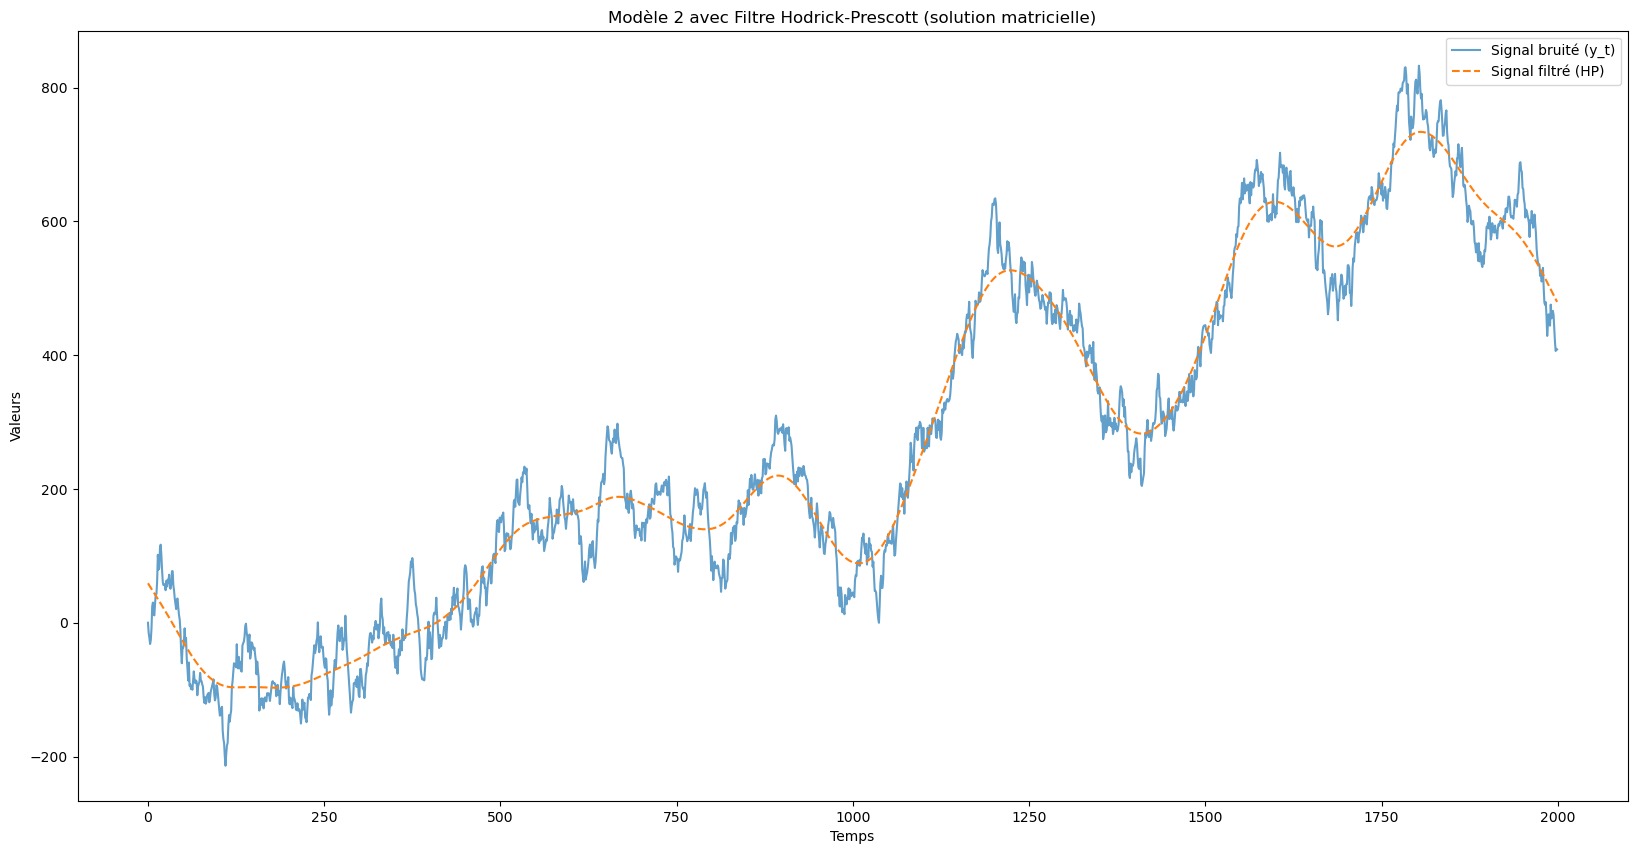

In [8]:
# Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_filtered, objective_value = apply_HP_filter_cvxpy(y_t_model2, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

### L1 filter

In [9]:
# Paramètres d'exécution
n = 2000
sigma = 15
p = 0.99
b = 0.5
T1 = 100
T2 = 20
m = 5
n_lambda = 10

#### Model 1

Calibrated λ (average): 863.1956175838422


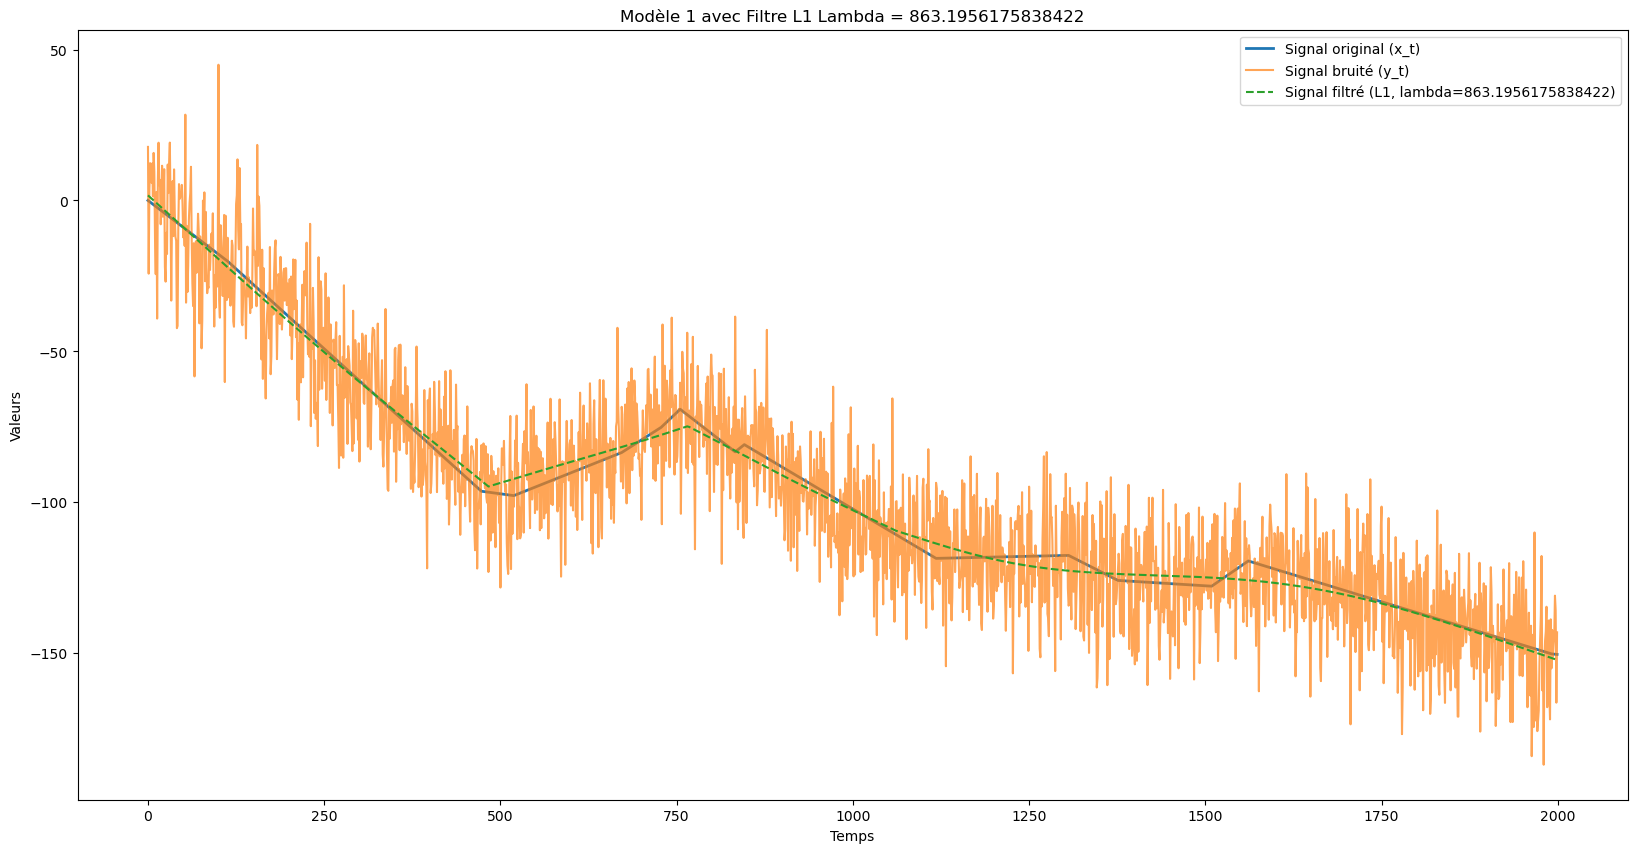

In [10]:
#Générer les données
x_t_model1, y_t_model1 = generate_model1_data(n=n, sigma=sigma, p=p, b=b)
lambda_fixed = calibrate_lambda_fixed(y_t_model1, periods=7, lambda_max_cap=1e4)

# Matrice D pour la série complète
D = getD(n, diff_order=2)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model1, D, lambda_fixed)

# Graphique des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t_model1, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t_model1, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label=f"Signal filtré (L1, lambda={lambda_fixed})", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre L1 Lambda = {lambda_fixed}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

#### Model 2

Calibrated λ (average): 121.13338871258699


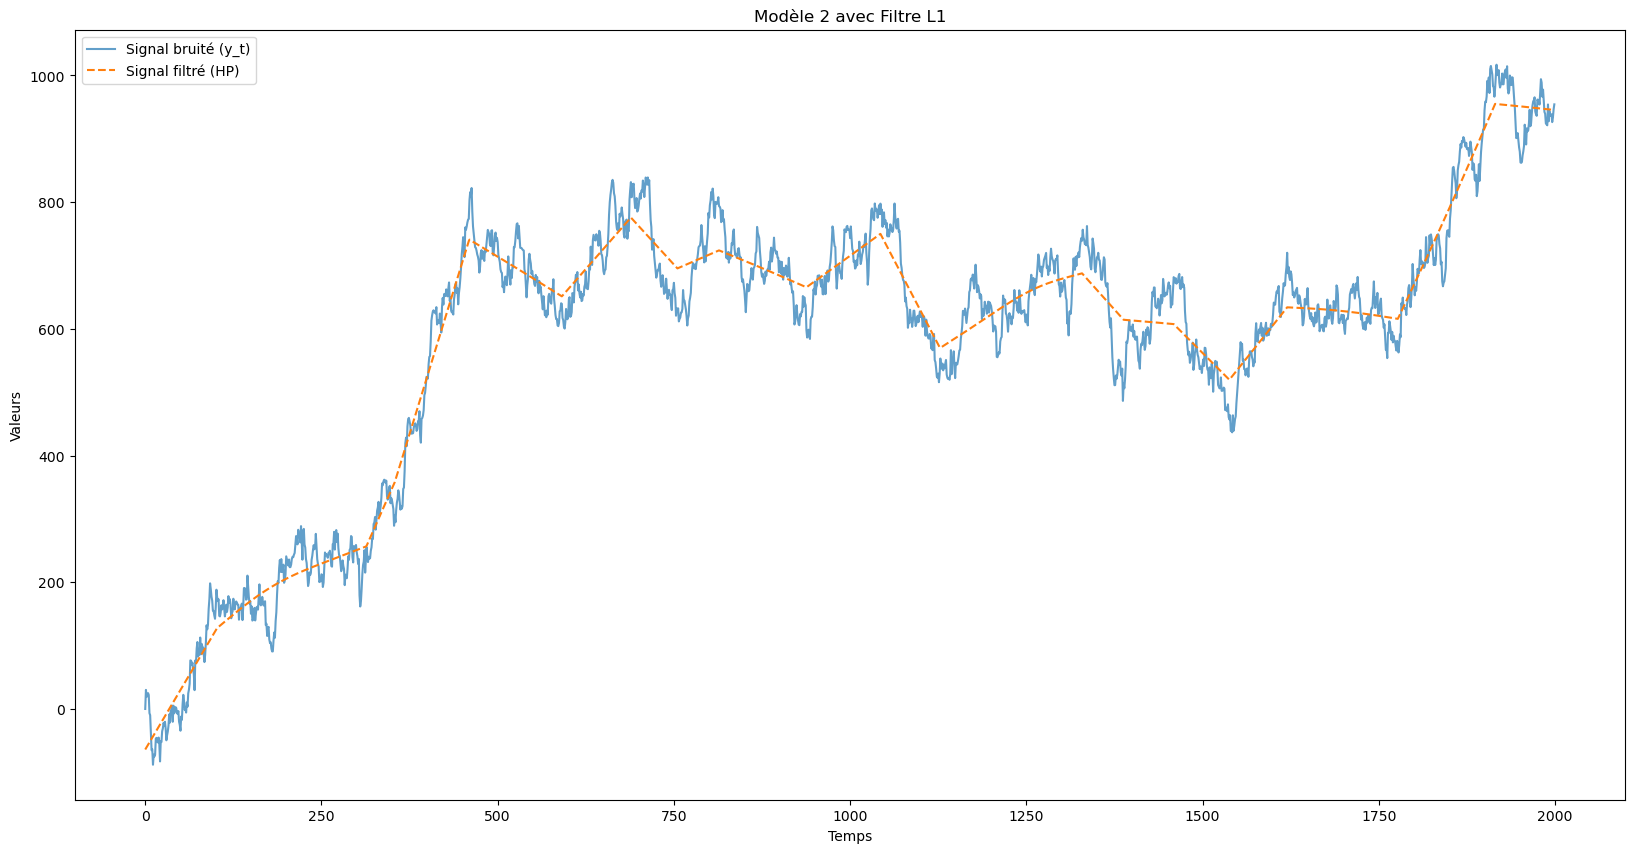

In [11]:
#Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)
lambda_fixed = calibrate_lambda_fixed(y_t_model2, periods=30, lambda_max_cap=1e4)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model2, D, lambda_fixed)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre L1")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

In [12]:
y_t_model2

array([  0.        ,  30.07327169,  19.09032824, ..., 933.43727186,
       946.44123655, 954.27973521])

### Momentum Trading With L1 filter and SP500

[*********************100%%**********************]  1 of 1 completed


Calibrated λ (average): 150.70650444860902


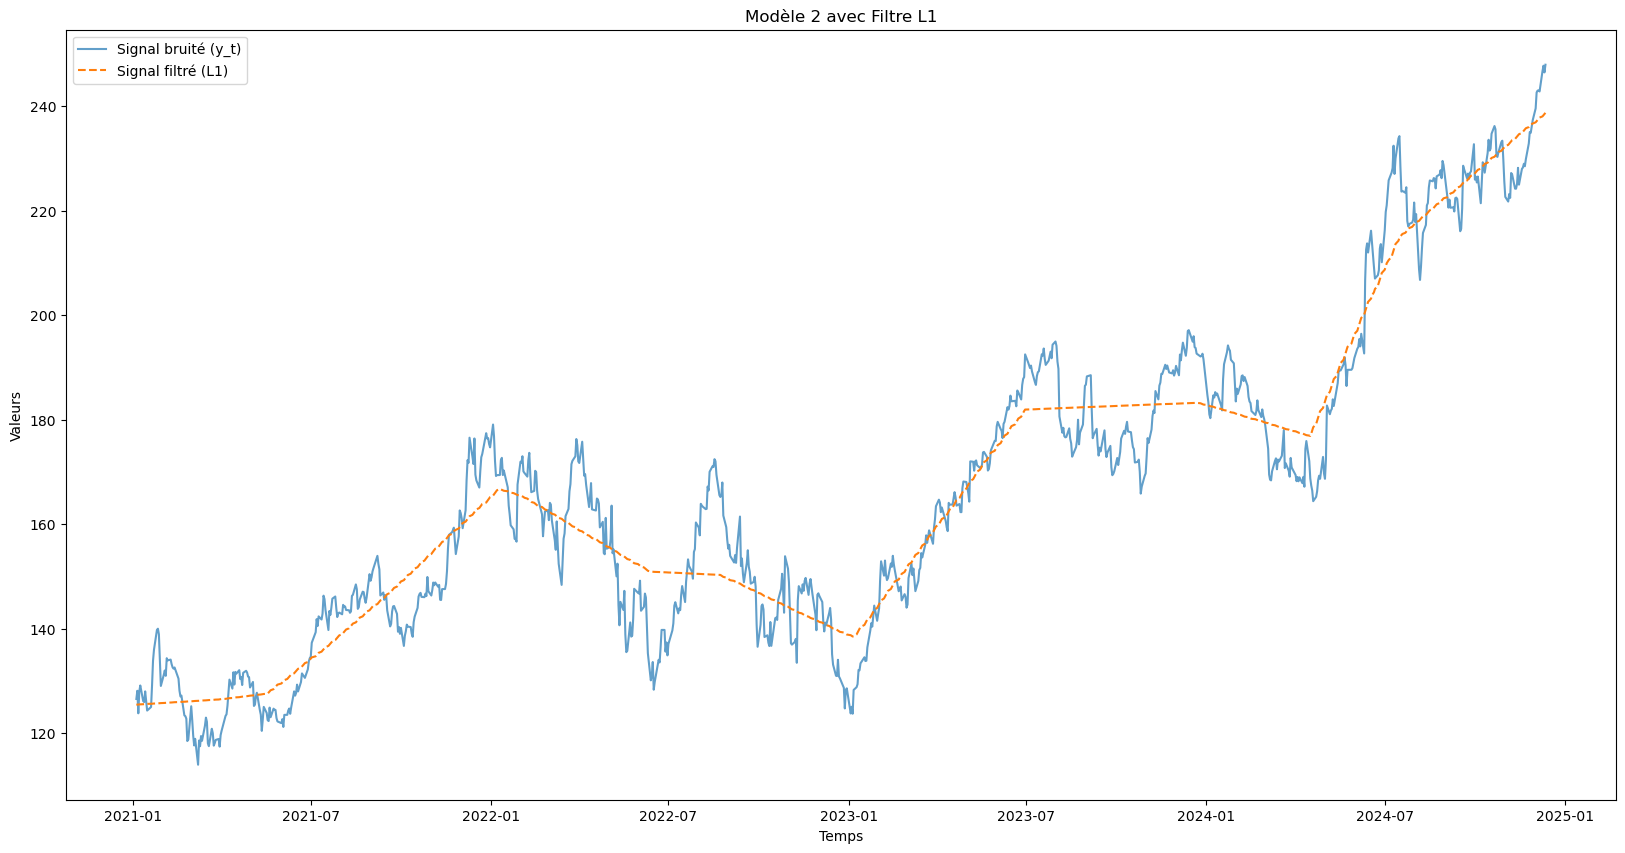

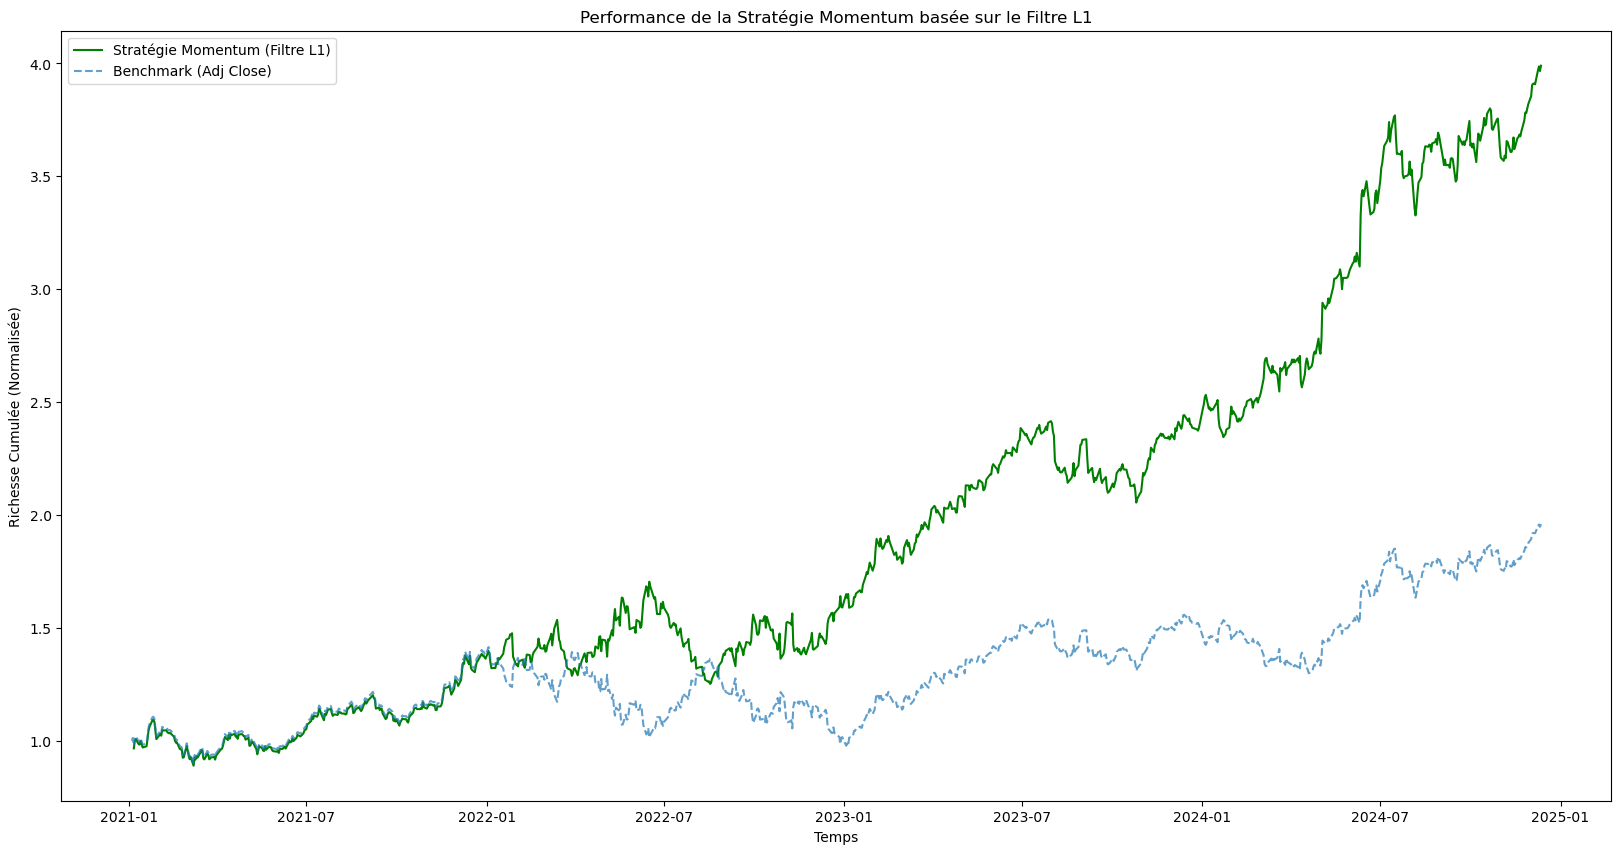

Strategy Annualized Return: 0.4217
Benchmark Annualized Return: 0.1829
Strategy Annualized Volatility: 0.2659
Benchmark Annualized Volatility: 0.2667
Strategy Sharpe Ratio: 1.5860
Benchmark Sharpe Ratio: 0.6855
Strategy Max Drawdown: -0.2653
Benchmark Max Drawdown: -0.3091
Strategy Sortino Ratio: 2.2950
Benchmark Sortino Ratio: 1.0390


In [203]:
ticker = "AAPL"
#ticker='TQQQ'
data = yf.download(ticker, start="2021-01-01", end="2024-12-13")['Adj Close']

lambda_fixed = calibrate_lambda_fixed(data.values , periods=15, lambda_max_cap=1e4)
# Taille des données et matrice D
n = len(data.values)
D = getD(n, diff_order=2)

# Aplatir les données
x_filtered = optimize_l1_filter(data.values.flatten(), D, lambda_fixed)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(data.index, data.values.flatten(), label="Signal bruité (y_t)", alpha=0.7)
plt.plot(data.index, x_filtered, label="Signal filtré (L1)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre L1")
plt.xlabel("Temps")  # Temps en x-axis
plt.ylabel("Valeurs")
plt.show()

results = pd.DataFrame({
    "Date": data.index,
    "Price": data.values.flatten(),
    "Filter": x_filtered
})
results.set_index("Date", inplace=True)

def generate_momentum_signals(Filter):
    """
    Génère des signaux d'achat et de vente basés sur les différences du signal filtré.
    Args:
        Filter (array): Signal filtré

    Returns:
        signals (array): Tableau de signaux (-1 pour vente, 1 pour achat, 0 sinon)
    """
    signals = np.zeros(len(Filter)+1)  # Initialisation des signaux
    for t in range(1, len(Filter)+1):
        if t + 1 < len(signals):  # Vérification pour éviter les erreurs d'index
            if Filter[t] - Filter[t-1] > 0:
                signals[t+1] = 1  # Signal d'achat
            elif Filter[t] - Filter[t-1] < 0:
                signals[t+1] = -1  # Signal de vente
    return signals

results["Signal"] = generate_momentum_signals(results['Filter'].to_numpy())[0:results.shape[0]]
results["Return"]=results["Price"].pct_change()

def backtest_momentum_strategy(signals, returns):
    """
    Calcule les rendements de la stratégie momentum basée sur les signaux.
    Args:
        data (array): Prix d'origine
        signals (array): Signaux d'achat/vente

    Returns:
        cumulative_returns (array): Richesse cumulée de la stratégie
    """
    strategy_returns = signals * returns  # Rendements de la stratégie
    cumulative_returns = np.cumprod(1 + strategy_returns)  # Richesse cumulée
    return cumulative_returns

# Backtester la stratégie
signal=results["Signal"][2:]
returns=results["Return"][2:]
cumulative_strategy = backtest_momentum_strategy(signal,returns)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(data.index[2:], cumulative_strategy, label="Stratégie Momentum (Filtre L1)", color='green')
plt.plot(data.index, data.values / data.values[0], label="Benchmark (Adj Close)", linestyle="--", alpha=0.7)
plt.title("Performance de la Stratégie Momentum basée sur le Filtre L1")
plt.xlabel("Temps")
plt.ylabel("Richesse Cumulée (Normalisée)")
plt.legend()
plt.show()


def calculate_performance_stats(strategy_returns, benchmark_returns, freq=252):
    """
    Calcule les statistiques de performance pour une stratégie et un benchmark.

    Args:
        strategy_returns (array): Rendements journaliers de la stratégie.
        benchmark_returns (array): Rendements journaliers du benchmark.
        freq (int): Fréquence des données (252 pour données journalières).

    Returns:
        stats (dict): Dictionnaire contenant les statistiques de performance.
    """
    stats = {}
    
    # Rendement annualisé
    stats['Strategy Annualized Return'] = np.prod(1 + strategy_returns) ** (freq / len(strategy_returns)) - 1
    stats['Benchmark Annualized Return'] = np.prod(1 + benchmark_returns) ** (freq / len(benchmark_returns)) - 1
    
    # Volatilité annualisée
    stats['Strategy Annualized Volatility'] = np.std(strategy_returns) * np.sqrt(freq)
    stats['Benchmark Annualized Volatility'] = np.std(benchmark_returns) * np.sqrt(freq)
    
    # Ratio de Sharpe
    sharpe_ratio_strategy = stats['Strategy Annualized Return'] / stats['Strategy Annualized Volatility']
    sharpe_ratio_benchmark = stats['Benchmark Annualized Return'] / stats['Benchmark Annualized Volatility']
    stats['Strategy Sharpe Ratio'] = sharpe_ratio_strategy
    stats['Benchmark Sharpe Ratio'] = sharpe_ratio_benchmark
    
    # Drawdown
    def max_drawdown(returns):
        cumulative = np.cumprod(1 + returns)
        peak = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - peak) / peak
        return drawdown.min()
    
    stats['Strategy Max Drawdown'] = max_drawdown(strategy_returns)
    stats['Benchmark Max Drawdown'] = max_drawdown(benchmark_returns)
    
    # Ratio de Sortino
    def downside_deviation(returns, target=0):
        downside = returns[returns < target]
        return np.std(downside) * np.sqrt(freq)

    stats['Strategy Sortino Ratio'] = stats['Strategy Annualized Return'] / downside_deviation(strategy_returns)
    stats['Benchmark Sortino Ratio'] = stats['Benchmark Annualized Return'] / downside_deviation(benchmark_returns)
    
    return stats

# Calcul des statistiques
benchmark_returns = results["Return"][2:]  # Rendements du benchmark
stats = calculate_performance_stats(signal * returns, benchmark_returns)

# Afficher les statistiques
for k, v in stats.items():
    print(f"{k}: {v:.4f}")

# Visualiser les drawdowns
def plot_drawdowns(returns, title):
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak

    plt.figure(figsize=(20, 6))
    plt.plot(drawdown, color='red')
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Drawdown")
    plt.show()



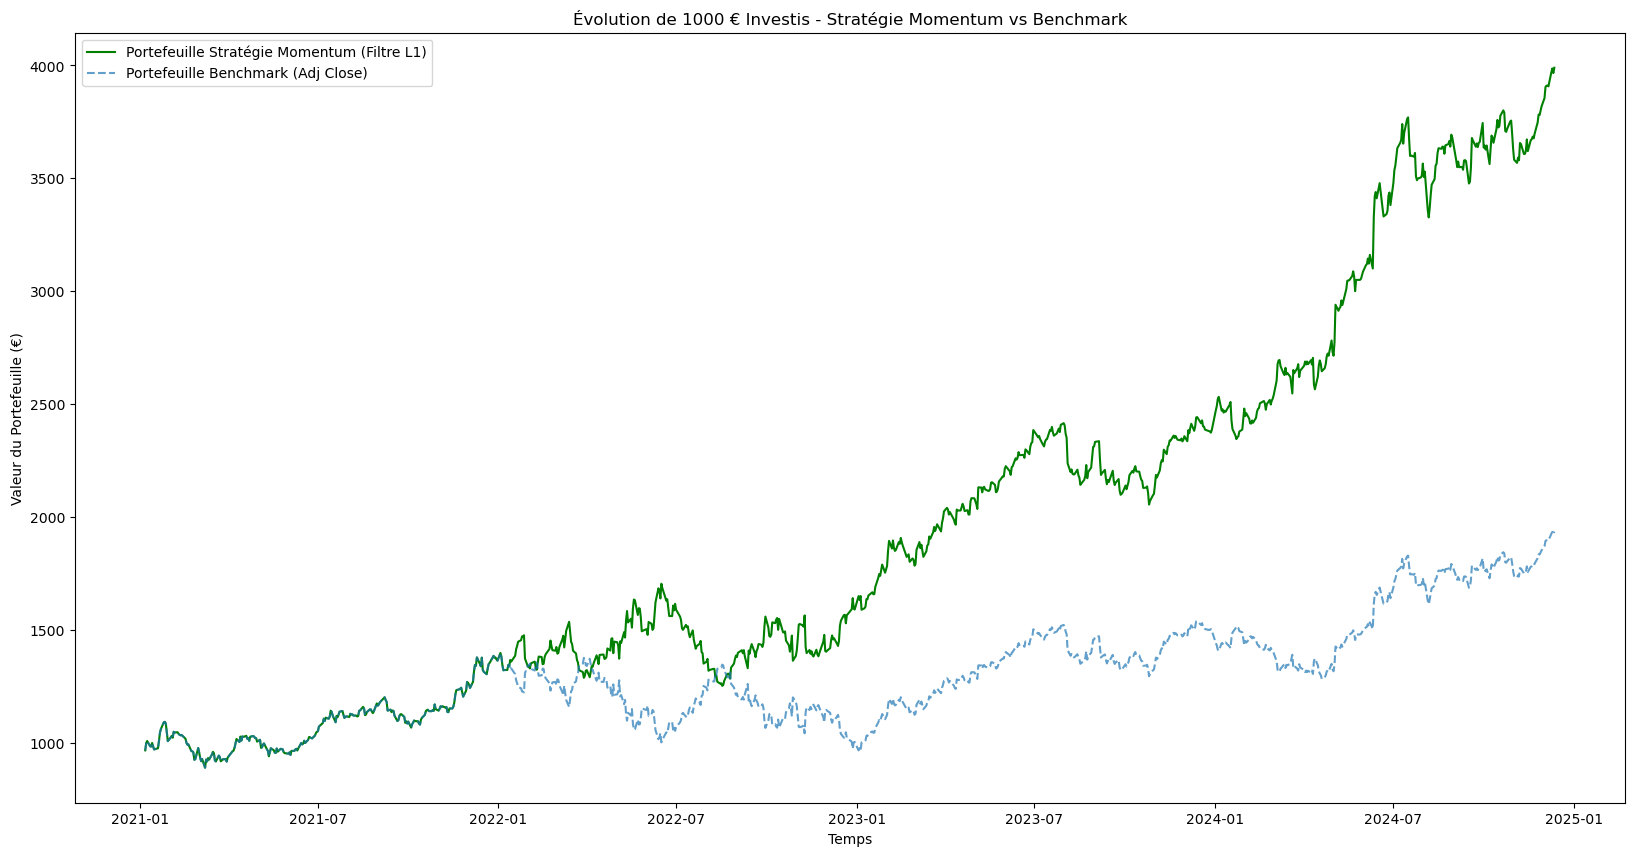

Valeur finale de l'investissement dans la stratégie : 3990.01 €
Valeur finale de l'investissement dans le benchmark : 1935.54 €


/var/folders/pm/gyny_pw906z6y671sxfgb40h0000gn/T/ipykernel_999/1263454070.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valeur finale de l'investissement dans la stratégie : {strategy_portfolio[-1]:.2f} €")
/var/folders/pm/gyny_pw906z6y671sxfgb40h0000gn/T/ipykernel_999/1263454070.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valeur finale de l'investissement dans le benchmark : {benchmark_portfolio[-1]:.2f} €")


In [204]:
def investment_evolution(strategy_returns, benchmark_returns, initial_investment=1000):
    """
    Calcule l'évolution d'un investissement initial pour la stratégie et le benchmark.

    Args:
        strategy_returns (array): Rendements journaliers de la stratégie.
        benchmark_returns (array): Rendements journaliers du benchmark.
        initial_investment (float): Montant initial investi.

    Returns:
        strategy_portfolio (array): Valeur cumulée de l'investissement dans la stratégie.
        benchmark_portfolio (array): Valeur cumulée de l'investissement dans le benchmark.
    """
    strategy_cumulative = np.cumprod(1 + strategy_returns)
    benchmark_cumulative = np.cumprod(1 + benchmark_returns)
    
    strategy_portfolio = initial_investment * strategy_cumulative
    benchmark_portfolio = initial_investment * benchmark_cumulative
    
    return strategy_portfolio, benchmark_portfolio

# Calcul de l'évolution des investissements
initial_investment = 1000
strategy_returns = signal * returns
benchmark_returns = results["Return"][2:]

strategy_portfolio, benchmark_portfolio = investment_evolution(strategy_returns, benchmark_returns, initial_investment)

# Visualisation de l'évolution de l'investissement
plt.figure(figsize=(20, 10))
plt.plot(data.index[2:], strategy_portfolio, label="Portefeuille Stratégie Momentum (Filtre L1)", color='green')
plt.plot(data.index[2:], benchmark_portfolio, label="Portefeuille Benchmark (Adj Close)", linestyle="--", alpha=0.7)
plt.title(f"Évolution de {initial_investment} € Investis - Stratégie Momentum vs Benchmark")
plt.xlabel("Temps")
plt.ylabel("Valeur du Portefeuille (€)")
plt.legend()
plt.show()

# Résumé final des investissements
print(f"Valeur finale de l'investissement dans la stratégie : {strategy_portfolio[-1]:.2f} €")
print(f"Valeur finale de l'investissement dans le benchmark : {benchmark_portfolio[-1]:.2f} €")


In [208]:
len(generate_momentum_signals(results['Filter'].to_numpy()))

994

In [209]:
results['Filter']

Date
2021-01-04    125.443378
2021-01-05    125.460404
2021-01-06    125.477430
2021-01-07    125.494456
2021-01-08    125.511483
                 ...    
2024-12-06    237.843360
2024-12-09    238.070652
2024-12-10    238.297943
2024-12-11    238.525235
2024-12-12    238.752527
Name: Filter, Length: 993, dtype: float64